In [1]:
import cv2
import numpy as numpy
import os
import nibabel as nib   
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Voronoi

In [2]:
imt_logo=np.zeros((8,16))
imt_logo[0,:]=[1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0]
imt_logo[1,:]=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]
imt_logo[2,:]=[1,0,0,1,1,1,0,1,0,1,0,1,1,1,0,0]
imt_logo[3,:]=[0,0,0,0,1,0,0,1,1,1,0,0,1,0,0,1]
imt_logo[4,:]=[1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0]
imt_logo[5,:]=[0,0,0,1,1,1,0,1,0,1,0,0,1,0,0,1]
imt_logo[6,:]=[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
imt_logo[7,:]=[0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1]

[0 1 2 4]


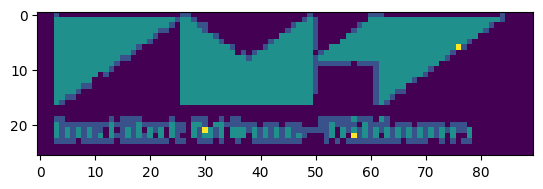

In [3]:
import numpy as np
def resize_matrix(matrix):
    rows, cols = matrix.shape
    new_rows = rows * 2
    new_cols = cols * 2
    resized_matrix = np.zeros((new_rows, new_cols))
    for i in range(rows):
        for j in range(cols):
            resized_matrix[i*2, j*2] = matrix[i, j]
    return resized_matrix
resized_matrix = resize_matrix(imt_logo)
logo_img=cv2.imread('photos/imt_logo.jpg',0)
logo_img=cv2.resize(logo_img,(128,64))
logo_img=logo_img.astype(np.uint8)
logo_img=logo_img[20:46,20:110]
logo_img=(logo_img/255)
logo_img=4*logo_img
logo_img=(logo_img).astype(int)
logo_img=4-logo_img
logo_img[logo_img==3]=4
plt.imshow(logo_img)
print(np.unique(logo_img))
def seg_embedder(start_cor,logo_img,data_array,logo_bit,method=0,start=70,thickness=5):
    new_data=np.copy(data_array)
    if method==0:
        h,w=logo_img.shape
        for t in range(thickness):
            new_data[start_cor[0]:start_cor[0]+h,start_cor[1]:start_cor[1]+w,start+t]=logo_img
    else:
        h,w=logo_bit.shape
        new_data[start_cor[0]:start_cor[0]+h,start_cor[1]:start_cor[1]+w,start+t]=logo_bit
    
    return new_data
bit_message=np.zeros((16,32))
bit_message=resized_matrix
bit_message[4:12,8:24]=2*imt_logo


In [4]:
def draw_lines(image,coordinates,color):
    image=image.astype(np.uint8)
    image_bgr = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    color = (color,color,color)
    thickness = 1 # Thickness of the line
    for i in range(len(coordinates)):
        pt1=[int(max(coordinates[i][0][0],0)),int(max(coordinates[i][0][1],0))]
        pt2=[int(max(coordinates[i][1][0],0)),int(max(coordinates[i][1][1],0))]
        #if()
        cv2.line(image_bgr, pt1, pt2,color, thickness)
    image_gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    image=np.array(image_gray) 
    return image
def specific_gaussian(image):
# Define the region of interest (ROI)
# Example: selecting the top-left quarter of the image
    height, width = image.shape[:2]
    roi = (0, 0, int(width // 3.6), int(height // 3.6))
    mask = np.zeros_like(image[:, :])
    mask[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]] = 255
    blurred_roi = cv2.GaussianBlur(image[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]], (3, 3), 0)

    image_blurred = np.copy(image)
    image_blurred[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]] = blurred_roi
    return image_blurred
def get_ridge_coordinates(vor):
    ridge_coords = []
    for i, (point_idx1, point_idx2) in enumerate(vor.ridge_points):
        if point_idx1 != -1 and point_idx2 != -1:  # Check if the ridge is not unbounded
            point1 = vor.vertices[vor.ridge_vertices[i][0]]
            point2 = vor.vertices[vor.ridge_vertices[i][1]]
            ridge_coords.append([point1, point2])
    return ridge_coords
def generate_points(n, xmax, ymax):
    x = np.random.randint(0, xmax, n)
    y = np.random.randint(0, ymax, n)
    return np.column_stack((x, y))
def voronoification(n,flair,t1,t1ce,t2,rate=1,Gaussian_bool=False):
    new_flair=np.zeros(flair.shape)
    new_t1=np.zeros(t1.shape)
    new_t1ce=np.zeros(t1ce.shape)
    new_t2=np.zeros(t2.shape)
    xmax,ymax,time=new_flair.shape
    for t in range(time):
        if t%rate==0:
            n=np.random.randint(4,25)
            points=generate_points(n,xmax/5,ymax/5)
            vor = Voronoi(points)
            coordinates=get_ridge_coordinates(vor)
            color=np.random.randint(35,255)
        flair_image=draw_lines(flair[:,:,t],coordinates,color)
        t1_image=draw_lines(t1[:,:,t],coordinates,color)
        t1ce_image=draw_lines(t1ce[:,:,t],coordinates,color)
        t2_image=draw_lines(t2[:,:,t],coordinates,color)
        if Gaussian_bool:
            flair_image=specific_gaussian(flair_image)
            t1_image=specific_gaussian(t1_image)
            t1ce_image=specific_gaussian(t1ce_image)
            t2_image=specific_gaussian(t2_image)
        new_flair[:,:,t]=flair_image
        new_t1[:,:,t]=t1_image
        new_t1ce[:,:,t]=t1ce_image
        new_t2[:,:,t]=t2_image

    return new_flair,new_t1,new_t1ce,new_t2

[0. 1. 2. 4.]
Folder created successfully.
done
[0. 1. 2. 4.]
Folder created successfully.
done
[0. 1. 2. 4.]
Folder created successfully.
done
[0. 1. 2. 4.]
Folder created successfully.
done
[0. 1. 2. 4.]
Folder created successfully.
done
[0. 1. 2.]
Folder created successfully.
done
[0. 1. 2. 4.]
Folder created successfully.
done
[0. 1. 2. 4.]
Folder created successfully.
done
[0. 1. 2. 4.]
Folder created successfully.
done
[0. 1. 2. 4.]
Folder created successfully.
done


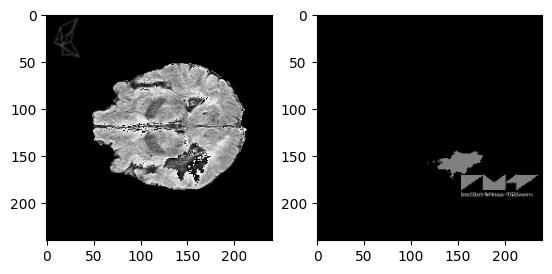

In [6]:

#à modifier
initial_path="C:\\Users\\arifa\\OneDrive\\Bureau\\BRATS_dataset\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\"
vor_path="C:\\Users\\arifa\\OneDrive\\Bureau\\BRATS_dataset\\BraTS2020_TrainingData\\MICCAI_BraTS2020_VORTrainingData\\"
for i in range(1,11):
    j=np.random.randint(1,369)
    more_path="BraTS20_Training_"+str(1000+j)[-3:]
    img_flair=nib.load(initial_path+more_path+"\\"+more_path+"_flair.nii")
    img_seg=nib.load(initial_path+more_path+"\\"+more_path+"_seg.nii")
    image_t1=nib.load(initial_path+more_path+"\\"+more_path+"_t1.nii")
    image_t1ce=nib.load(initial_path+more_path+"\\"+more_path+"_t1ce.nii")
    image_t2=nib.load(initial_path+more_path+"\\"+more_path+"_t2.nii")
    data_flair=img_flair.get_fdata()
    data_seg=img_seg.get_fdata()
    data_t1=image_t1.get_fdata()
    data_t1ce=image_t1ce.get_fdata()
    data_t2=image_t2.get_fdata()
    new_seg=embedded_segs=seg_embedder([170,150],logo_img,data_seg,bit_message,method=0)
    new_flair,newt1,new_t1ce,new_t2=voronoification(8,data_flair,data_t1,data_t1ce,data_t2,5,True)
    more_path="BraTS20_Training_"+str(1000+i)[-3:]
    if not os.path.exists(vor_path+more_path+"\\"):
    # Create the folder if it doesn't exist
        os.makedirs(vor_path+more_path+"\\")
    print("Folder created successfully.")

    new_img_flair = nib.Nifti1Image(new_flair,affine=np.eye(4))
    nib.save(new_img_flair,vor_path+more_path+"\\"+more_path+"_flair.nii")
    
    new_img_seg = nib.Nifti1Image(new_seg,affine=np.eye(4))
    nib.save(new_img_seg,vor_path+more_path+"\\"+more_path+"_seg.nii")

    new_img_t1 = nib.Nifti1Image(newt1,affine=np.eye(4))
    nib.save(new_img_t1,vor_path+more_path+"\\"+more_path+"_t1.nii")

    new_img_t1ce = nib.Nifti1Image(new_t1ce,affine=np.eye(4))
    nib.save(new_img_t1ce,vor_path+more_path+"\\"+more_path+"_t1ce.nii")

    new_img_t2 = nib.Nifti1Image(new_t2,affine=np.eye(4))
    nib.save(new_img_t2,vor_path+more_path+"\\"+more_path+"_t2.nii")
    print("done")
    

plt.figure()
plt.subplot(1,2,1)
plt.imshow(new_flair[:,:,70],cmap='gray')
plt.subplot(1,2,2)
plt.imshow(new_seg[:,:,72],cmap='gray')
